<h1>Network Analysis with Python</h1>

<li>Networks are connected bi-directional graphs
<li>Nodes mark the entities in a network
<li>Edges mark the relationships in a network

<h2>Examples of networks</h2>
<li>Facebook friends
<li>Other social networks
<li>transportation networks
<li>Power grids
<li>Internet routers
<li>Activity networks
<li>Many others

<h2>Questions we're interested in</h2>
<li>Shortest path between two nodes
<li>Connectedness
<li>Centrality
<li>Clustering
<li>Communicability

<h1>networkx</h1>
<li>Python package for networks 
<li>Nodes and edges can contain data
<li>Nodes can be (hashable!) python objects

<h3>Constructing a simple network</h3>

<b>Necessary imports</b>

In [1]:
import networkx as nx
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

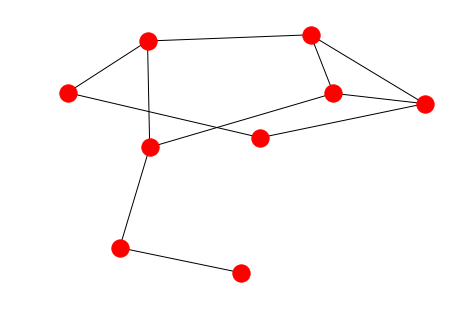

In [2]:
simple_network = nx.Graph()
nodes = [1, 2, 3, 4, 5, 6, 7, 8]
edges = [(1, 2), (2, 3), (1, 3), (4, 5), (2, 7), (1, 9),
         (3, 4), (4, 5), (4, 9), (5, 6), (7, 8), (8, 9)]
simple_network.add_nodes_from(nodes)
simple_network.add_edges_from(edges)
nx.draw(simple_network)

<h1>Add labels to the nodes</h1>

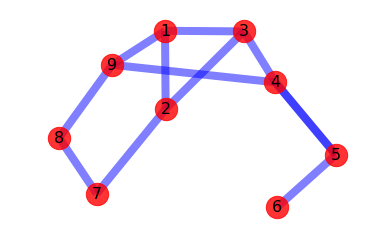

In [3]:
pos = nx.spring_layout(simple_network)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(simple_network, pos,
                       node_color='r',
                       node_size=500,
                       alpha=0.8)

# edges
# nx.draw_networkx_edges(sub_graph,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(simple_network, pos,
                       edgelist=edges,
                       width=8, alpha=0.5, edge_color='b')


node_name = {}
for node in simple_network.nodes():
    node_name[node] = str(node)


nx.draw_networkx_labels(simple_network, pos, node_name, font_size=16)

plt.axis('off')
plt.show()  # display

<h4>Simple queries on the network</h4>

In [4]:
simple_network.has_edge(2, 9)
# simple_network.has_node(2)
# simple_network.number_of_edges()
# simple_network.number_of_nodes()
# simple_network.order()
# len(simple_network)

False

<h3>Iterating over a network</h3>

In [5]:
for n in simple_network.nodes_iter():
    print(n)

1
2
3
4
5
6
7
8
9


In [6]:
for a in simple_network.adjacency_iter():
    print(a)

(1, {2: {}, 3: {}, 9: {}})
(2, {1: {}, 3: {}, 7: {}})
(3, {2: {}, 1: {}, 4: {}})
(4, {5: {}, 3: {}, 9: {}})
(5, {4: {}, 6: {}})
(6, {5: {}})
(7, {2: {}, 8: {}})
(8, {7: {}, 9: {}})
(9, {1: {}, 4: {}, 8: {}})


In [7]:
for e in simple_network.edges_iter():
    print(e)

(1, 2)
(1, 3)
(1, 9)
(2, 3)
(2, 7)
(3, 4)
(4, 5)
(4, 9)
(5, 6)
(7, 8)
(8, 9)


In [8]:
for d in simple_network.degree_iter():
    print(d)

(1, 3)
(2, 3)
(3, 3)
(4, 3)
(5, 2)
(6, 1)
(7, 2)
(8, 2)
(9, 3)


<h3>Types of graph</h3>


In [9]:
G = nx.Graph()  # Undirected simple graph
d = nx . DiGraph()  # directed simple graph
m = nx . MultiGraph()  # undirected with parallel edges
h = nx . MultiDiGraph()  # directed with parallel edges

<h4>Shortest path</h4>

In [10]:
print(nx.shortest_path(simple_network, 6, 8))
print(nx.shortest_path_length(simple_network, 6, 8))

[6, 5, 4, 9, 8]
4


<h2>Weighted Edges</h2>
<li>Example: A network of travel times between locations

<h4>We can use Google Distance Matrix API to get travel times</h4>
<li>Uses addresses to construct a distance matrix
<li>Free version uses latitudes and longitudes
<li>We can find latitudes and longitudes using the function we wrote as homework

<h4>We'll add a get_lat_lon function to our geocoding function to return lat,lon in google's required format</h4>

In [11]:
# Our geocoding data getter is useful here!


def get_json_data(response, country, types):
    data = response.json()
    result_list = list()
    for result in data['results']:
        if not country == 'ALL':
            if not country in [x['long_name'] for x in result['address_components'] if 'country' in x['types']]:
                continue
        address = result['formatted_address']
        lat = result['geometry']['location']['lat']
        lng = result['geometry']['location']['lng']
        if types:
            result_list.append((address, lat, lng, result['types']))
        else:
            result_list.append((address, lat, lng))
    return result_list


def get_geolocation_data(address_string, format="JSON", country="ALL", types=False):
    format = format.lower()
    address = '_'.join(address_string.split())
    url = 'https://maps.googleapis.com/maps/api/geocode/%s?address=%s' % (
        format, address)
    try:
        import requests
        response = requests.get(url)
        if not response.status_code == 200:
            return None
        func = 'get_' + format + '_data'
        return globals()[func](response, country, types)
    except:
        return None

# It is a little different from the video here. Some of you might have errors using the video's code, if so, run the following.
# If the following code still gives you errors, run it multiple times.
# Note that the original code is indeed correct.
def get_lat_lon(address):
    data = get_geolocation_data(address, format='JSON')
    result1 = str(data[0][1])
    result2 = str(data[0][2])
    result = result1 + ',' + result2
    return result

In [12]:
get_lat_lon("Ellington in the Park, Riverside Drive, New York, NY")

'40.8025603,-73.97186049999999'

<h4>Now we can construct the distance matrix api url</h4>

In [13]:
addresses = [
    "Columbia University, New York, NY",
    "Amity Hall Uptown, Amsterdam Avenue, New York, NY",
    "Ellington in the Park, Riverside Drive, New York, NY",
    'Chaiwali, Lenox Avenue, New York, NY',
    "Grant's Tomb, West 122nd Street, New York, NY",
    'Pisticci, La Salle Street, New York, NY',
    'Nicholas Roerich Museum, West 107th Street, New York, NY',
    'Audubon Terrace, Broadway, New York, NY',
    'Apollo Theater, New York, NY'
]

In [14]:
latlons = ''
for address in addresses:
    latlon = get_lat_lon(address)
    print(get_lat_lon(address))
    latlons += latlon + '|'
print(latlons)

40.8075355,-73.9625727
40.8022031,-73.9647008
40.8025603,-73.97186049999999
40.806757,-73.945847
40.8134045,-73.9630671
40.8141746,-73.9603204
40.80293899999999,-73.969002
40.83325749999999,-73.94585529999999
40.810018,-73.95005600000002
40.8075355,-73.9625727|40.8022031,-73.9647008|40.8025603,-73.97186049999999|40.806757,-73.945847|40.8134045,-73.9630671|40.8141746,-73.9603204|40.80293899999999,-73.969002|40.83325749999999,-73.94585529999999|40.810018,-73.95005600000002|


In [15]:
distance_url = 'https://maps.googleapis.com/maps/api/distancematrix/json?origins='
distance_url += latlons
distance_url += '&destinations='
distance_url += latlons
# Set the mode walking, driving, cycling
mode = 'walking'
distance_url += '&mode=' + mode
print(distance_url)

https://maps.googleapis.com/maps/api/distancematrix/json?origins=40.8075355,-73.9625727|40.8022031,-73.9647008|40.8025603,-73.97186049999999|40.806757,-73.945847|40.8134045,-73.9630671|40.8141746,-73.9603204|40.80293899999999,-73.969002|40.83325749999999,-73.94585529999999|40.810018,-73.95005600000002|&destinations=40.8075355,-73.9625727|40.8022031,-73.9647008|40.8025603,-73.97186049999999|40.806757,-73.945847|40.8134045,-73.9630671|40.8141746,-73.9603204|40.80293899999999,-73.969002|40.83325749999999,-73.94585529999999|40.810018,-73.95005600000002|&mode=walking


<h4>Then let's get the distances and construct a graph</h4>

C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

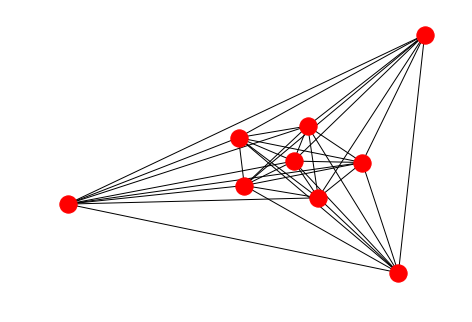

In [16]:
import requests
data = requests.get(distance_url).json()
all_rows = data['rows']
address_graph = nx.Graph()
address_graph.add_nodes_from(addresses)
for i in range(len(all_rows)):
    origin = addresses[i]
    for j in range(len(all_rows[i]['elements'])):
        duration = all_rows[i]['elements'][j]['duration']['value']
        destination = addresses[j]
        address_graph.add_edge(origin, destination, d=duration)
        # print(origin,destination,duration)
nx.draw(address_graph)

C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

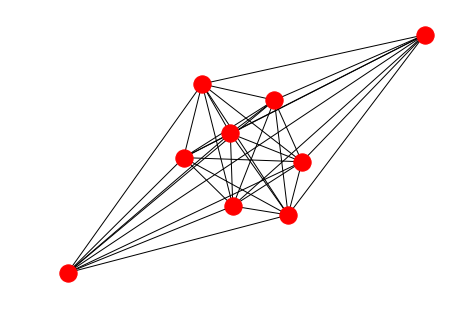

In [17]:
nx.draw(address_graph)

<h4>Functionalize this for reuse</h4>

In [18]:
def get_route_graph(address_list, mode='walking'):
    latlons = ''
    for address in addresses:
        latlon = get_lat_lon(address)
        latlons += latlon + '|'
    distance_url = 'https://maps.googleapis.com/maps/api/distancematrix/json?origins='
    distance_url += latlons
    distance_url += '&destinations='
    distance_url += latlons
    # Set the mode walking, driving, cycling
    mode = 'driving'
    distance_url += '&mode=' + mode
    import requests
    data = requests.get(distance_url).json()
    all_rows = data['rows']
    address_graph = nx.Graph()
    address_graph.add_nodes_from(addresses)
    for i in range(len(all_rows)):
        origin = addresses[i]
        for j in range(len(all_rows[i]['elements'])):
            if i == j:
                continue
            duration = all_rows[i]['elements'][j]['duration']['value']
            destination = addresses[j]
            address_graph.add_edge(origin, destination, d=duration)
    return address_graph


address_graph = get_route_graph(addresses)

<h4>Test the function by drawing it with node and edge labels</h4>

In [19]:
for edge in address_graph.edges():
    print(edge, address_graph.get_edge_data(*edge))

In [20]:
for n in address_graph.edges_iter():
    print(n)

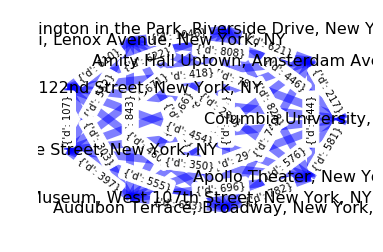

In [21]:
address_graph = get_route_graph(addresses)
pos = nx.circular_layout(address_graph)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(address_graph, pos,
                       node_color='r',
                       node_size=2000,
                       alpha=0.001)

# edges

nx.draw_networkx_edges(address_graph, pos, edgelist=address_graph.edges(
), width=8, alpha=0.5, edge_color='b')

nx.draw_networkx_edge_labels(address_graph, pos, font_size=10)
node_name = {}
for node in address_graph.nodes():
    node_name[node] = str(node)


nx.draw_networkx_labels(address_graph, pos, node_name, font_size=16)

plt.axis('off')
plt.show()  # display

<h3>Yikes! Unreadable!</h3>
<li>Let's see what the edge weights are</li>

In [22]:
for edge in address_graph.edges():
    print(edge, address_graph.get_edge_data(*edge))

('Columbia University, New York, NY', 'Amity Hall Uptown, Amsterdam Avenue, New York, NY') {'d': 217}
('Columbia University, New York, NY', 'Ellington in the Park, Riverside Drive, New York, NY') {'d': 446}
('Columbia University, New York, NY', 'Chaiwali, Lenox Avenue, New York, NY') {'d': 780}
('Columbia University, New York, NY', "Grant's Tomb, West 122nd Street, New York, NY") {'d': 245}
('Columbia University, New York, NY', 'Pisticci, La Salle Street, New York, NY') {'d': 239}
('Columbia University, New York, NY', 'Nicholas Roerich Museum, West 107th Street, New York, NY') {'d': 296}
('Columbia University, New York, NY', 'Audubon Terrace, Broadway, New York, NY') {'d': 576}
('Columbia University, New York, NY', 'Apollo Theater, New York, NY') {'d': 581}
('Amity Hall Uptown, Amsterdam Avenue, New York, NY', 'Ellington in the Park, Riverside Drive, New York, NY') {'d': 621}
('Amity Hall Uptown, Amsterdam Avenue, New York, NY', 'Chaiwali, Lenox Avenue, New York, NY') {'d': 808}
('Amit

<h4>Let's make this readable</h4>

In [23]:
for edge in address_graph.edges():
    duration = address_graph.get_edge_data(*edge)['d']
    address_graph.get_edge_data(*edge)['d'] = int(duration / 60)
    print(address_graph.get_edge_data(*edge))

{'d': 3}
{'d': 7}
{'d': 13}
{'d': 4}
{'d': 3}
{'d': 4}
{'d': 9}
{'d': 9}
{'d': 10}
{'d': 13}
{'d': 6}
{'d': 7}
{'d': 4}
{'d': 12}
{'d': 10}
{'d': 17}
{'d': 10}
{'d': 11}
{'d': 7}
{'d': 13}
{'d': 13}
{'d': 10}
{'d': 9}
{'d': 14}
{'d': 14}
{'d': 3}
{'d': 1}
{'d': 5}
{'d': 7}
{'d': 7}
{'d': 6}
{'d': 9}
{'d': 5}
{'d': 11}
{'d': 11}
{'d': 13}


<h4>Now let's look a the graph</h4>

C:\Users\think\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


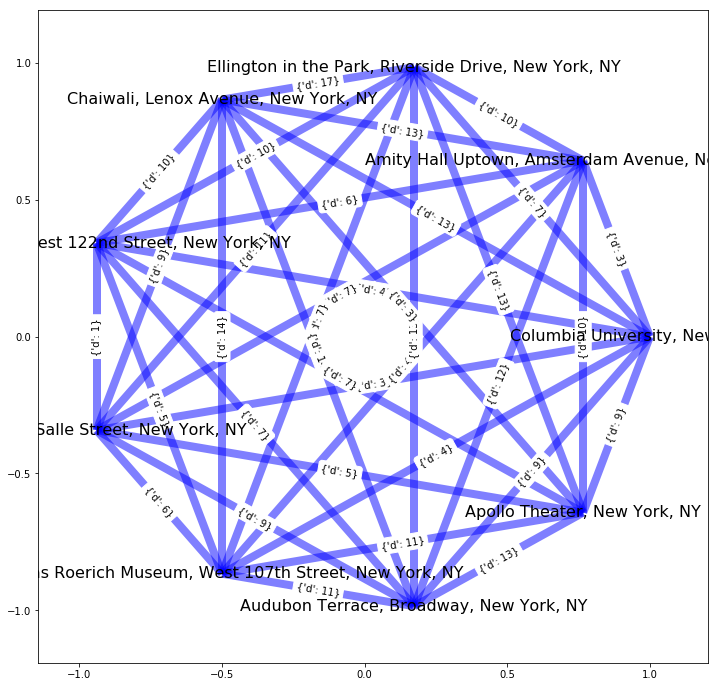

In [24]:
pos = nx.circular_layout(address_graph)  # positions for all nodes
# Let's draw a big graph so that it is clearer
fig = plt.figure(1, figsize=(12, 12))
# nodes
nx.draw_networkx_nodes(address_graph, pos,
                       node_color='r',
                       node_size=2000,
                       alpha=0.001)

# edges

nx.draw_networkx_edges(address_graph, pos, edgelist=address_graph.edges(
), width=8, alpha=0.5, edge_color='b')

nx.draw_networkx_edge_labels(address_graph, pos, font_size=10)
node_name = {}
for node in address_graph.nodes():
    node_name[node] = str(node)


nx.draw_networkx_labels(address_graph, pos, node_name, font_size=16)
# fig.axis('off')
fig.show()  # display

In [25]:
def get_route_graph(address_list, mode='walking'):
    latlons = ''
    for address in addresses:
        latlon = get_lat_lon(address)
        latlons += latlon + '|'
    distance_url = 'https://maps.googleapis.com/maps/api/distancematrix/json?origins='
    distance_url += latlons
    distance_url += '&destinations='
    distance_url += latlons
    # Set the mode walking, driving, cycling
    mode = 'driving'
    distance_url += '&mode=' + mode
    import requests
    data = requests.get(distance_url).json()
    all_rows = data['rows']
    address_graph = nx.Graph()
    address_graph.add_nodes_from(addresses)
    for i in range(len(all_rows)):
        origin = addresses[i]
        for j in range(len(all_rows[i]['elements'])):
            if i == j:
                continue
            duration = all_rows[i]['elements'][j]['duration']['value']
            destination = addresses[j]
            address_graph.add_edge(origin, destination, d=int(duration / 60))
    return address_graph


address_graph = get_route_graph(addresses)

<h4>Let's remove a few edges (randomly)</h4>

In [26]:
for edge in address_graph.edges():
    import random
    r = random.random()
    if r < 0.75:  # get rid of 60% of the edges
        address_graph.remove_edge(*edge)

<h4>And draw it again</h4>

C:\Users\think\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


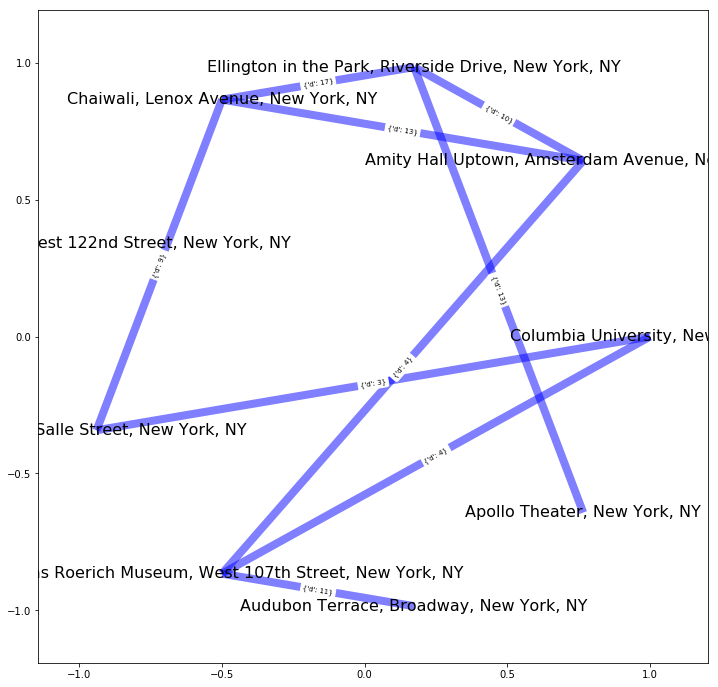

In [27]:
pos = nx.circular_layout(address_graph)  # positions for all nodes
plt.figure(1, figsize=(12, 12))  # Let's draw a big graph so that it is clearer
# nodes
nx.draw_networkx_nodes(address_graph, pos,
                       node_color='r',
                       node_size=2000,
                       alpha=0.001)

# edges

nx.draw_networkx_edges(address_graph, pos, edgelist=address_graph.edges(
), width=8, alpha=0.5, edge_color='b')

nx.draw_networkx_edge_labels(address_graph, pos, font_size=7)
node_name = {}
for node in address_graph.nodes():
    node_name[node] = str(node)


nx.draw_networkx_labels(address_graph, pos, node_name, font_size=16)
# fig.axis('off')
fig.show()  # display

In [28]:
print(addresses)

['Columbia University, New York, NY', 'Amity Hall Uptown, Amsterdam Avenue, New York, NY', 'Ellington in the Park, Riverside Drive, New York, NY', 'Chaiwali, Lenox Avenue, New York, NY', "Grant's Tomb, West 122nd Street, New York, NY", 'Pisticci, La Salle Street, New York, NY', 'Nicholas Roerich Museum, West 107th Street, New York, NY', 'Audubon Terrace, Broadway, New York, NY', 'Apollo Theater, New York, NY']


<h4>Shortest path and shortest duration</h4>

In [29]:
print(nx.shortest_path(address_graph, 'Amity Hall Uptown, Amsterdam Avenue, New York, NY',
                       'Chaiwali, Lenox Avenue, New York, NY'))
print(nx.dijkstra_path(address_graph, 'Amity Hall Uptown, Amsterdam Avenue, New York, NY',
                       'Chaiwali, Lenox Avenue, New York, NY'))
print(nx.dijkstra_path_length(address_graph, 'Amity Hall Uptown, Amsterdam Avenue, New York, NY',
                              'Chaiwali, Lenox Avenue, New York, NY', weight='d'))

['Amity Hall Uptown, Amsterdam Avenue, New York, NY', 'Chaiwali, Lenox Avenue, New York, NY']
['Amity Hall Uptown, Amsterdam Avenue, New York, NY', 'Chaiwali, Lenox Avenue, New York, NY']
13


In [30]:
"""
The reason we are running the same cell one more time is that we RANDOMLY 
cut several edges in the previous steps. Now we need the original network
so that we can avoid the NetworkXNoPath error.

Run this cell, and run the next cell. It will work fine.
"""

def get_route_graph(address_list, mode='walking'):
    latlons = ''
    for address in addresses:
        latlon = get_lat_lon(address)
        latlons += latlon + '|'
    distance_url = 'https://maps.googleapis.com/maps/api/distancematrix/json?origins='
    distance_url += latlons
    distance_url += '&destinations='
    distance_url += latlons
    # Set the mode walking, driving, cycling
    mode = 'driving'
    distance_url += '&mode=' + mode
    import requests
    data = requests.get(distance_url).json()
    all_rows = data['rows']
    address_graph = nx.Graph()
    address_graph.add_nodes_from(addresses)
    for i in range(len(all_rows)):
        origin = addresses[i]
        for j in range(len(all_rows[i]['elements'])):
            if i == j:
                continue
            duration = all_rows[i]['elements'][j]['duration']['value']
            destination = addresses[j]
            address_graph.add_edge(origin, destination, d=int(duration / 60))
    return address_graph


address_graph = get_route_graph(addresses)

In [31]:
# [print(n1,n2,nx.shortest_path_length(n1,n2),nx.dijkstra_path_length(n1,n2,weight='d')) for n1 in address_graph.nodes() for n2 in address_graph.nodes()]
[print(n1, n2,
       nx.shortest_path_length(address_graph, n1, n2),
       nx.dijkstra_path_length(address_graph, n1, n2, weight='d')) for n1 in address_graph.nodes() for n2 in address_graph.nodes() if not n1 == n2]

Columbia University, New York, NY Amity Hall Uptown, Amsterdam Avenue, New York, NY 1 3
Columbia University, New York, NY Ellington in the Park, Riverside Drive, New York, NY 1 7
Columbia University, New York, NY Chaiwali, Lenox Avenue, New York, NY 1 11
Columbia University, New York, NY Grant's Tomb, West 122nd Street, New York, NY 1 4
Columbia University, New York, NY Pisticci, La Salle Street, New York, NY 1 3
Columbia University, New York, NY Nicholas Roerich Museum, West 107th Street, New York, NY 1 4
Columbia University, New York, NY Audubon Terrace, Broadway, New York, NY 1 9
Columbia University, New York, NY Apollo Theater, New York, NY 1 8
Amity Hall Uptown, Amsterdam Avenue, New York, NY Columbia University, New York, NY 1 3
Amity Hall Uptown, Amsterdam Avenue, New York, NY Ellington in the Park, Riverside Drive, New York, NY 1 10
Amity Hall Uptown, Amsterdam Avenue, New York, NY Chaiwali, Lenox Avenue, New York, NY 1 13
Amity Hall Uptown, Amsterdam Avenue, New York, NY Grant

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [32]:
for edge in address_graph.edges():
    print(edge, address_graph.get_edge_data(*edge))

('Columbia University, New York, NY', 'Amity Hall Uptown, Amsterdam Avenue, New York, NY') {'d': 3}
('Columbia University, New York, NY', 'Ellington in the Park, Riverside Drive, New York, NY') {'d': 7}
('Columbia University, New York, NY', 'Chaiwali, Lenox Avenue, New York, NY') {'d': 13}
('Columbia University, New York, NY', "Grant's Tomb, West 122nd Street, New York, NY") {'d': 4}
('Columbia University, New York, NY', 'Pisticci, La Salle Street, New York, NY') {'d': 3}
('Columbia University, New York, NY', 'Nicholas Roerich Museum, West 107th Street, New York, NY') {'d': 4}
('Columbia University, New York, NY', 'Audubon Terrace, Broadway, New York, NY') {'d': 9}
('Columbia University, New York, NY', 'Apollo Theater, New York, NY') {'d': 9}
('Amity Hall Uptown, Amsterdam Avenue, New York, NY', 'Ellington in the Park, Riverside Drive, New York, NY') {'d': 10}
('Amity Hall Uptown, Amsterdam Avenue, New York, NY', 'Chaiwali, Lenox Avenue, New York, NY') {'d': 13}
('Amity Hall Uptown, Am

<h2>Graph drawing options</h2>
<li>nltk uses matplotlib to draw graphs
<li>limited, but useful, functionalities
<h3>Let's take a look!</h3>

<b>Differnetiating edges by weight</b>

C:\Users\think\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


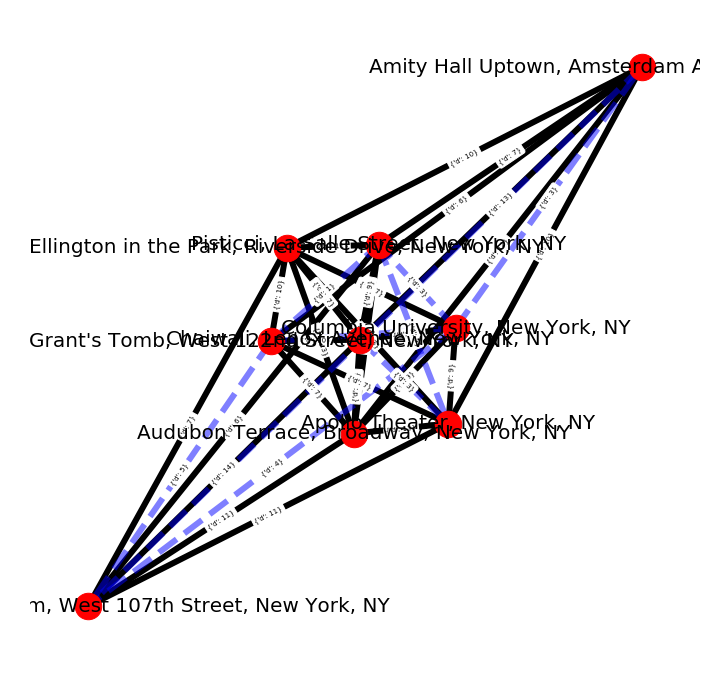

In [33]:
# Divide edges into two groups based on weight
# Easily extendable to n-groups

elarge = [(u, v) for (u, v, d) in address_graph.edges(data=True) if d['d'] > 5]
esmall = [(u, v)
          for (u, v, d) in address_graph.edges(data=True) if d['d'] <= 5]

pos = nx.spring_layout(address_graph)  # positions for all nodes
plt.figure(1, figsize=(12, 12))  # Let's draw a big graph so that it is clearer

# nodes
nx.draw_networkx_nodes(address_graph, pos, node_size=700)

# edges. draw the larger weight edges in solid lines and smaller weight edges in dashed lines
nx.draw_networkx_edges(address_graph, pos, edgelist=elarge,
                       width=6)
nx.draw_networkx_edges(address_graph, pos, edgelist=esmall,
                       width=6, alpha=0.5, edge_color='b', style='dashed')

# labels
nx.draw_networkx_labels(address_graph, pos, font_size=20,
                        font_family='sans-serif')

nx.draw_networkx_edge_labels(address_graph, pos, font_size=7)

plt.axis('off')
# plt.savefig("address_graph.png") # save as png if you need to use it in a report or web app
fig.show()  # display

<h4>highlight the shortest path</h4>


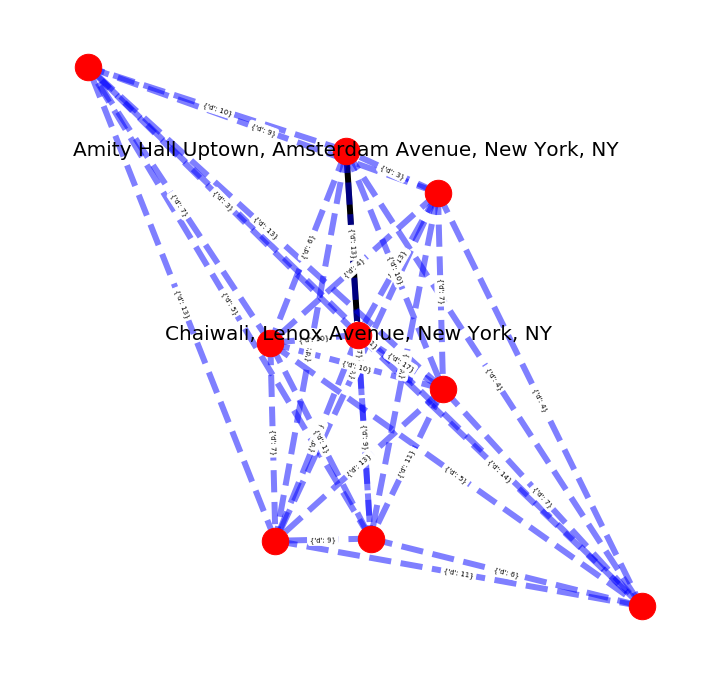

In [34]:
origin = 'Amity Hall Uptown, Amsterdam Avenue, New York, NY'
destination = 'Chaiwali, Lenox Avenue, New York, NY'
shortest_path = nx.dijkstra_path(address_graph, origin, destination)
shortest_path_edges = list()
for i in range(len(shortest_path) - 1):
    shortest_path_edges.append((shortest_path[i], shortest_path[i + 1]))
    shortest_path_edges.append((shortest_path[i + 1], shortest_path[i]))

path_edges = list()
other_edges = list()
node_label_list = dict()
node_label_list = {n: '' for n in address_graph.nodes()}
for edge in address_graph.edges():
    if edge in shortest_path_edges:
        path_edges.append(edge)
        node_label_list[edge[0]] = edge[0]
        node_label_list[edge[1]] = edge[1]
    else:
        other_edges.append(edge)

pos = nx.spring_layout(address_graph)  # positions for all nodes
fig = plt.figure(1, figsize=(12, 12))
# nodes
nx.draw_networkx_nodes(address_graph, pos, node_size=700)

# edges. draw the larger weight edges in solid lines and smaller weight edges in dashed lines
nx.draw_networkx_edges(address_graph, pos, edgelist=path_edges,
                       width=6)
nx.draw_networkx_edges(address_graph, pos, edgelist=other_edges,
                       width=6, alpha=0.5, edge_color='b', style='dashed')

# labels

nx.draw_networkx_labels(address_graph, pos, font_size=20,
                        font_family='sans-serif', labels=node_label_list)
nx.draw_networkx_edge_labels(address_graph, pos, font_size=7)

plt.axis('off')
# plt.savefig("address_graph.png") # save as png if you need to use it in a report or web app
plt.show()  # display

<b>Question</b> How would you remove edge labels from all but the shortest path?

<h4>Working with a network</h4>


<b>Given an address, generate a <i>sorted by distance</i> list of all other addresses

In [35]:
location = 'Amity Hall Uptown, Amsterdam Avenue, New York, NY'
distance_list = list()
for node in address_graph.nodes():
    if node == location:
        continue
    distance = nx.dijkstra_path_length(address_graph, location, node)
    distance_list.append((node, distance))
from operator import itemgetter
print(sorted(distance_list, key=itemgetter(1)))

[('Columbia University, New York, NY', 1), ('Ellington in the Park, Riverside Drive, New York, NY', 1), ('Chaiwali, Lenox Avenue, New York, NY', 1), ("Grant's Tomb, West 122nd Street, New York, NY", 1), ('Pisticci, La Salle Street, New York, NY', 1), ('Nicholas Roerich Museum, West 107th Street, New York, NY', 1), ('Audubon Terrace, Broadway, New York, NY', 1), ('Apollo Theater, New York, NY', 1)]


<b>Get all paths from one location  to another</b>

In [36]:
list(nx.all_simple_paths(address_graph, 'Amity Hall Uptown, Amsterdam Avenue, New York, NY',
                         'Chaiwali, Lenox Avenue, New York, NY'))

[['Amity Hall Uptown, Amsterdam Avenue, New York, NY',
  'Columbia University, New York, NY',
  'Ellington in the Park, Riverside Drive, New York, NY',
  'Chaiwali, Lenox Avenue, New York, NY'],
 ['Amity Hall Uptown, Amsterdam Avenue, New York, NY',
  'Columbia University, New York, NY',
  'Ellington in the Park, Riverside Drive, New York, NY',
  "Grant's Tomb, West 122nd Street, New York, NY",
  'Chaiwali, Lenox Avenue, New York, NY'],
 ['Amity Hall Uptown, Amsterdam Avenue, New York, NY',
  'Columbia University, New York, NY',
  'Ellington in the Park, Riverside Drive, New York, NY',
  "Grant's Tomb, West 122nd Street, New York, NY",
  'Pisticci, La Salle Street, New York, NY',
  'Chaiwali, Lenox Avenue, New York, NY'],
 ['Amity Hall Uptown, Amsterdam Avenue, New York, NY',
  'Columbia University, New York, NY',
  'Ellington in the Park, Riverside Drive, New York, NY',
  "Grant's Tomb, West 122nd Street, New York, NY",
  'Pisticci, La Salle Street, New York, NY',
  'Nicholas Roerich 

In [37]:
nx.all_simple_paths(address_graph,
                    'Amity Hall Uptown, Amsterdam Avenue, New York, NY',
                    'Chaiwali, Lenox Avenue, New York, NY')

<generator object _all_simple_paths_graph at 0x000001C67F9B3518>

<h2>Social networks</h2><br>
We will use the <a href="https://www.yelp.com/dataset_challenge">Yelp database challenge</a><br>
Data on:
    users,
    businesses,
    reviews,
    tips (try the mushroom burger!),
    check-in (special offers from yelp)

<h3>We're use the data in the users file (yelp_academic_dataset_user.json)</h3>

<h1>Important note!</h1>
<h3>The data on the yelp site has changed. If you want to follow along with the class video, do the following:</h3>
<li>Download the file "friends_graph" from the Files unit at the top of this week's class material
<li>Scroll down to the cell that says "G = nx.read_gpickle('friend_graph')" and run the rest of the notebook from that point onward
<li>If you want to use the new file, then do all the following cells EXCEPT for the "G = nx.read_gpickle('friend_graph')" cell</li>

<h4>Read the data from the data file and create several list variables to hold the data</h4>
<li>You could also use objects to store the data </li>

In [38]:
import json
import datetime
datafile = 'yelp_academic_dataset_user.json'
user_id_count = 1
user_id_dict = dict()
with open(datafile, 'r') as f:
    for line in f:
        data = json.loads(line)
        user_id = data.get('user_id')
        friends = data.get('friends')
        try:
            user_id_dict[user_id]
        except:
            user_id_dict[user_id] = user_id_count
            user_id_count += 1
print(len(user_id_dict))
user_data = list()
friends_data = list()
with open(datafile, 'r') as f:
    count = 0
    for line in f:
        data = json.loads(line)
        user_id = user_id_dict[data.get('user_id')]
        name = data.get('name')
        review_count = data.get('review_count')
        average_stars = data.get('average_stars')

        try:
            yelping_since = datetime.datetime.strptime(
                data.get('yelping_since').strip(), "%Y-%m").date()
        except:
            yelping_since = datetime.datetime.now()

        fans = data.get('fans')
        user_friends = data.get('friends')
        user_friends_list = list()
        for i in range(len(user_friends)):
            try:
                user_friends_list.append(user_id_dict[user_friends[i]])
            except:
                continue
        user_data.append([user_id, name, review_count,
                          yelping_since, average_stars, fans])
        friends_data.append([user_id, user_friends_list])
        count += 1
print(count)

366715
366715


In [39]:
friends_data[0:10]

[[1,
  [2,
   3,
   4,
   6,
   7,
   13,
   94,
   455,
   1084,
   1349,
   1435,
   1530,
   1531,
   1613,
   2444,
   2445,
   2533,
   2538,
   17719,
   2893,
   3069,
   3073,
   3074,
   3157,
   3343,
   22670,
   3620,
   4248,
   4253,
   4516,
   30177,
   5052,
   5058,
   5325,
   5595,
   5597,
   5598,
   5693,
   5695,
   184135,
   5779,
   5861,
   5868,
   5964,
   6048,
   194046,
   6415,
   6589,
   6592,
   7137,
   7493,
   7494,
   8401,
   8946,
   9300,
   60491,
   9937,
   10124,
   10497,
   10500,
   10680,
   11395,
   12304,
   12572,
   76809,
   13033,
   13220,
   13865,
   14238,
   14510,
   15522,
   96714,
   99664,
   16719,
   16981,
   17813,
   18087,
   19392,
   19847,
   20678,
   21598,
   23127,
   24311,
   24948,
   25311,
   25955,
   26217,
   27044,
   172549,
   174035,
   30633,
   31106,
   32577,
   32578,
   37456,
   40793,
   41526,
   43263,
   45436,
   45623,
   269821,
   46343,
   274420,
   46800,
   280613,
   47705,

<h2>Too much data for this class so let's cut it down</h2>

In [40]:
# Select a random(ish) list of nodes
friends_of_list = [1, 5, 15, 100, 2200, 3700, 13500, 23800,
                   45901, 78643, 112112, 198034, 267123, 298078, 301200, 353216]
node_super_set = set(friends_of_list)
# Get a superset of these nodes - the friends they are connected to
for n in friends_of_list:
    friends = friends_data[n - 1][1]
    node_super_set = node_super_set.union({f for f in friends})
node_super_list = list(node_super_set)
# Collect node data and edges for these nodes
node_data = dict()
edge_list = list()
for node in node_super_list:
    node_data[node] = user_data[node - 1]
    friends = friends_data[node - 1][1]
    edges = [(node, e) for e in friends if e in node_super_list]
    edge_list.extend(edges)

In [41]:
print(len(edge_list), len(node_super_list), len(node_data))

5718 317 317


In [42]:
for e in edge_list:
    if e[0] in node_super_list:
        continue
    if e[1] in node_super_list:
        continue
    print(e[0], e[1])

<h3>Make the graph</h3>

In [43]:
import networkx as nx

In [44]:
friend_graph = nx.Graph()
friend_graph.add_nodes_from(node_super_list)
friend_graph.add_edges_from(edge_list)
print(friend_graph.number_of_nodes(), friend_graph.number_of_edges())

317 2859


In [45]:
nx.write_gpickle(friend_graph, './friend_graph')

In [46]:
G = nx.read_gpickle('friend_graph')
len(G.neighbors(1))

206

In [47]:
# Querying the graph
len(friend_graph.neighbors(1))

206

C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

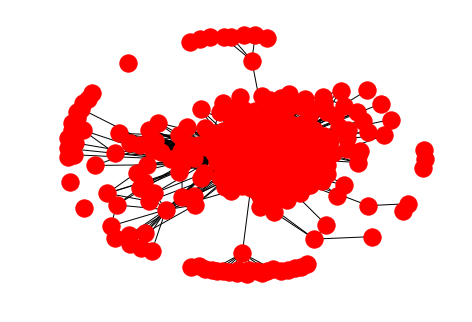

In [48]:
%matplotlib inline
nx.draw(friend_graph)

<h4>Let's remove disconnected nodes</h4>


In [49]:
count = 0
for n in friend_graph.nodes_iter():
    if friend_graph.degree(n) == 1:
        print(n)

364688
63653
69803
167099
257220
154849
170254
232849
47622
24141
92761
281183
348767
104065
301712
166554
238267
338645
174830
75584
93026
339862
227226
38836
155590


In [50]:
nodes = friend_graph.nodes()
for node in nodes:
    if friend_graph.degree(node) == 0:
        friend_graph.remove_node(node)

C:\Users\think\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


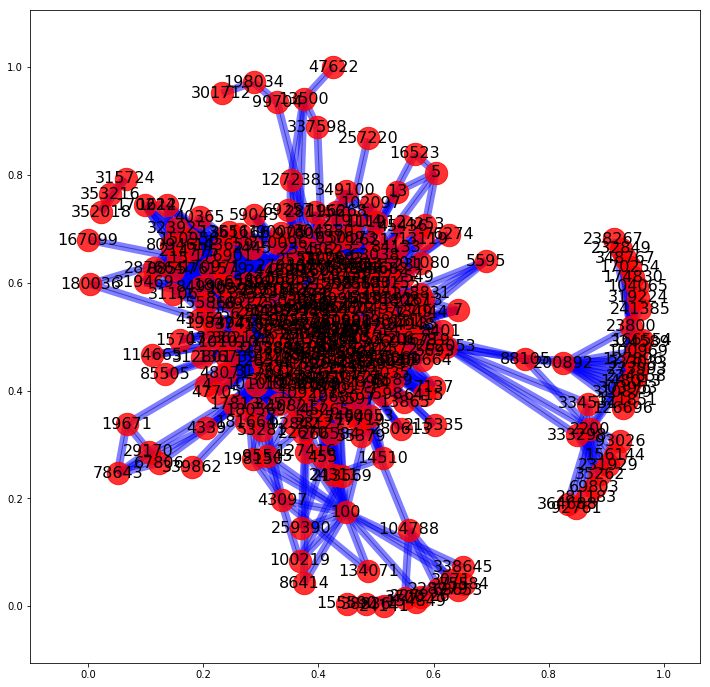

In [51]:
pos = nx.spring_layout(friend_graph)  # positions for all nodes
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(12, 12))
# pos
# nodes
nx.draw_networkx_nodes(friend_graph, pos,
                       node_color='r',
                       node_size=500,
                       alpha=0.8)

# edges
nx.draw_networkx_edges(friend_graph, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edges(friend_graph, pos,
                       width=8, alpha=0.5, edge_color='b')

node_name = {}
for node in friend_graph.nodes():
    node_name[node] = str(node)

nx.draw_networkx_labels(friend_graph, pos, node_name, font_size=16)

fig.show()

<h3>Start looking at different aspects of the graph</h3>

In [55]:
nx.shortest_path(friend_graph, 420079, 3700)
# If using the file friend_graph, comment the line above and uncomment the line below this one
# nx.shortest_path(friend_graph,100219,19671)

NetworkXError: The node 420079 is not in the graph.

In [56]:
nx.shortest_path_length(friend_graph, 420079, 928795)
# If using the file friend_graph, comment the line above and uncomment the line below this one
# nx.shortest_path_length(friend_graph,167099,47622)

NetworkXError: The node 420079 is not in the graph.

<h3>Graph components</h3>

<li>Let's see the number of connected components
<li>And then each connected component

In [57]:
print(len(list(nx.connected_components(friend_graph))))

2


In [58]:
for comp in nx.connected_components(friend_graph):
    print(comp)

{1, 2, 3, 4, 3073, 3074, 6, 7, 172549, 76809, 144395, 350729, 13, 5, 198150, 12304, 15, 22045, 233502, 43551, 78880, 53281, 128544, 136739, 3620, 280613, 13865, 88105, 148013, 80946, 80948, 304692, 41526, 45623, 69175, 1084, 5693, 63038, 5695, 213569, 298564, 281156, 273993, 60491, 1613, 24141, 37456, 204880, 345682, 55379, 9300, 3157, 16981, 23127, 3069, 47705, 43097, 224858, 3071, 92761, 94, 21598, 310879, 281183, 348767, 49251, 100, 26217, 100969, 344689, 228979, 3700, 84996, 85505, 104065, 55938, 11395, 110724, 48260, 326279, 69257, 67722, 362123, 146060, 248969, 22670, 178831, 16523, 61579, 101010, 5779, 301712, 60053, 364688, 4248, 101017, 2200, 166554, 291484, 4253, 15522, 84133, 156325, 18087, 59045, 63653, 92842, 69803, 196268, 14510, 108217, 167099, 200892, 13500, 337598, 343231, 317632, 324289, 238267, 265923, 257220, 334531, 20678, 121851, 253132, 5325, 316622, 361166, 46800, 8401, 9937, 102097, 45265, 338645, 19671, 155868, 67806, 25311, 269821, 154849, 5861, 126696, 13033

<h4>Largest connected component subgraph</h4>

C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

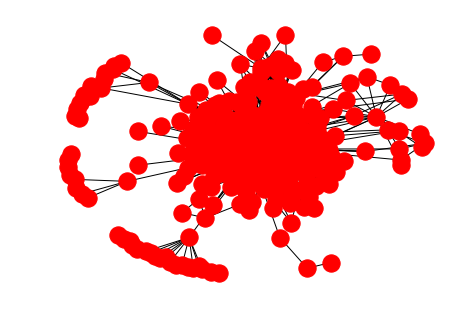

In [59]:
largest_size = 0
largest_graph = None
for g in nx.connected_component_subgraphs(friend_graph):
    if len(g) > largest_size:
        largest_size = len(g)
        largest_graph = g
nx.draw(largest_graph)

<h4>Smallest connected component</h4>

C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

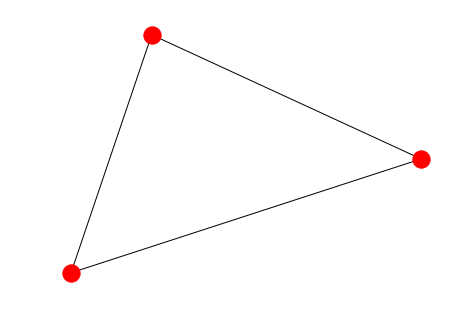

In [60]:
smallest_size = 100000
smallest_graph = None
for g in nx.connected_component_subgraphs(friend_graph):
    if len(g) < smallest_size:
        smallest_size = len(g)
        smallest_graph = g
nx.draw(smallest_graph)

In [61]:
# Find out node degrees in the graph
nx.degree(friend_graph)

{1: 206,
 2: 155,
 3: 68,
 4: 3,
 5: 4,
 6: 74,
 7: 5,
 13: 3,
 15: 24,
 94: 13,
 100: 17,
 455: 3,
 1084: 124,
 1349: 9,
 1435: 64,
 1530: 26,
 1531: 31,
 1613: 10,
 1806: 30,
 2200: 14,
 2444: 30,
 2445: 4,
 2533: 13,
 2538: 69,
 2893: 25,
 3069: 22,
 3071: 2,
 3073: 33,
 3074: 119,
 3157: 17,
 3343: 26,
 3620: 51,
 3700: 8,
 4248: 27,
 4253: 3,
 4339: 4,
 4516: 17,
 5052: 38,
 5058: 20,
 5325: 8,
 5595: 3,
 5597: 12,
 5598: 12,
 5693: 6,
 5695: 69,
 5779: 102,
 5861: 22,
 5868: 45,
 5964: 37,
 6048: 117,
 6415: 7,
 6589: 14,
 6592: 45,
 7137: 7,
 7493: 71,
 7494: 8,
 8401: 6,
 8946: 18,
 9300: 35,
 9937: 12,
 10124: 58,
 10497: 17,
 10500: 46,
 10680: 9,
 11395: 31,
 12304: 29,
 12572: 15,
 13033: 24,
 13119: 4,
 13220: 5,
 13500: 4,
 13865: 6,
 14238: 13,
 14510: 4,
 15522: 21,
 15707: 3,
 16523: 2,
 16719: 7,
 16981: 21,
 17719: 6,
 17813: 4,
 18087: 9,
 19392: 13,
 19671: 3,
 19847: 34,
 19958: 22,
 20678: 11,
 21598: 23,
 22045: 13,
 22670: 5,
 23127: 7,
 23800: 19,
 24141: 1,
 

<h4>Max degree. The yelp user with the most friends</h4>

In [62]:
# Highest degree
print(max(nx.degree(friend_graph).values()))


# Node with highest degree value
degrees = nx.degree(friend_graph)
print(max(degrees, key=degrees.get))

206
1


<h2>Network analysis algorithms</h2>
https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.html

<h3>Clustering</h3>
Clustering is a measure of how closely knit the nodes in a graph are. We can measure the degree to which a node belongs to a cluster and the degree to which the graph is clustered
- Node clustering coefficient: A measure that shows the degree to which a node belongs to a cluster
- Graph clustering coefficient: A measure that shows the degree to which a graph is clustered

C:\Users\think\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


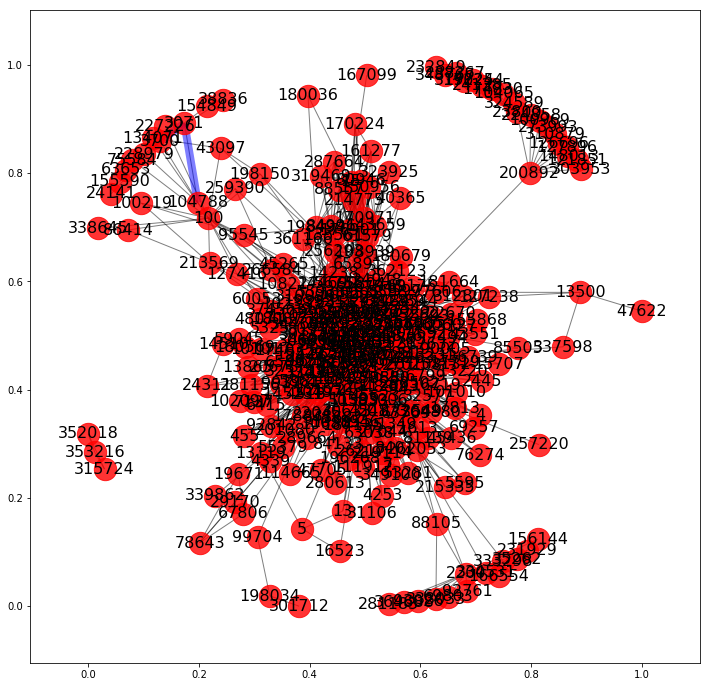

In [63]:
pos = nx.spring_layout(friend_graph)  # positions for all nodes
fig = plt.figure(1, figsize=(12, 12))
# pos
# nodes
nx.draw_networkx_nodes(friend_graph, pos,
                       node_color='r',
                       node_size=500,
                       alpha=0.8)

# edges
nx.draw_networkx_edges(friend_graph, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edges(friend_graph, pos,
                       edgelist=edges,
                       width=8, alpha=0.5, edge_color='b')

node_name = {}
for node in friend_graph.nodes():
    node_name[node] = str(node)

nx.draw_networkx_labels(friend_graph, pos, node_name, font_size=16)

fig.show()

In [64]:
nx.clustering(friend_graph)

{1: 0.10300734075301918,
 2: 0.1326351068286552,
 3: 0.3805970149253731,
 4: 1.0,
 5: 0.3333333333333333,
 6: 0.26471677156608664,
 7: 0.8,
 13: 0.6666666666666666,
 15: 0.38405797101449274,
 94: 0.6923076923076923,
 100: 0.08088235294117647,
 455: 1.0,
 1084: 0.2170207185942827,
 1349: 0.8055555555555556,
 1435: 0.408234126984127,
 1530: 0.6369230769230769,
 1531: 0.6172043010752688,
 1613: 0.6,
 1806: 0.5126436781609195,
 2200: 0.0989010989010989,
 2444: 0.5839080459770115,
 2445: 1.0,
 2533: 0.5512820512820513,
 2538: 0.38832054560954815,
 2893: 0.5433333333333333,
 3069: 0.5974025974025974,
 3071: 1.0,
 3073: 0.5681818181818182,
 3074: 0.22959692351516878,
 3157: 0.5514705882352942,
 3343: 0.6338461538461538,
 3620: 0.4415686274509804,
 3700: 0.07142857142857142,
 4248: 0.4586894586894587,
 4253: 1.0,
 4339: 0.5,
 4516: 0.7647058823529411,
 5052: 0.44950213371266,
 5058: 0.6368421052631579,
 5325: 0.7142857142857143,
 5595: 0.6666666666666666,
 5597: 0.8181818181818182,
 5598: 0.66

In [65]:
nx.average_clustering(friend_graph)

0.5813409642336658

C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\think\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\think\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

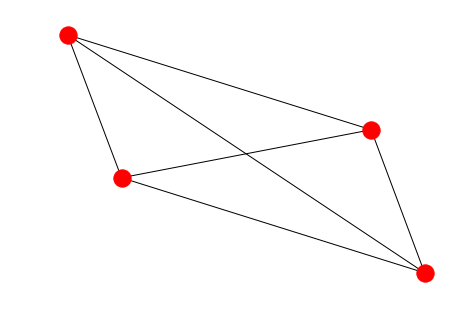

In [66]:
G = nx.complete_graph(4)
nx.draw(G)

In [67]:
nx.clustering(G)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

In [68]:
G.remove_edge(1, 2)

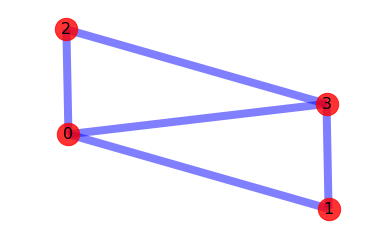

In [69]:
pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos,
                       node_color='r',
                       node_size=500,
                       alpha=0.8)

# edges
# nx.draw_networkx_edges(sub_graph,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(G, pos,
                       edgelist=G.edges(),
                       width=8, alpha=0.5, edge_color='b')


node_name = {}
for node in G.nodes():
    node_name[node] = str(node)


nx.draw_networkx_labels(G, pos, node_name, font_size=16)

plt.axis('off')
plt.show()  # display

In [70]:
nx.clustering(G)

{0: 0.6666666666666666, 1: 1.0, 2: 1.0, 3: 0.6666666666666666}

<h3>Node 0 has two neighbors: 1 and 2. Of the three possible edges, only two are actually present. So, its clustering coefficient is 2/3 or 0.667</h3>

<h2>Centrality and communicability</h2>
<b>Centrality</b> deals with identifying the most important nodes in a graph<p>
<b>Communicability</b> measures how easy it is to send a message from node i to node j
<li>closeness_centrality: (n-1)/sum(shortest path to all other nodes)
<li>betweenness_centrality: fraction of pair shortest paths that pass through node n
<li>degree centrality: fraction of nodes that n is connected to
<li>communicability: the sum of all walks from one node to every other node

In [71]:
from networkx.algorithms.centrality import closeness_centrality, communicability

<h3>Closeness centrality is a measure of how near a node is to every other node in a network</h3>
<h3>The higher the closeness centrality, the more central a node is</h3>
<h3>Roughly, because it can get to more nodes in shorter jumps</h3>

In [72]:
type(closeness_centrality(friend_graph))

dict

In [73]:
from collections import OrderedDict
cc = OrderedDict(sorted(
    closeness_centrality(friend_graph).items(),
    key=lambda x: x[1],
    reverse=True))
cc

OrderedDict([(1, 0.6125079094513101),
             (2, 0.5556082675897129),
             (1084, 0.5342012940573597),
             (3074, 0.5268202744503496),
             (6048, 0.5268202744503496),
             (99664, 0.5232057271127829),
             (5779, 0.5161234160858755),
             (52550, 0.5083815648445873),
             (298564, 0.5083815648445873),
             (348634, 0.49277696107714447),
             (6, 0.491189917724239),
             (64979, 0.49040022332275307),
             (7493, 0.48417291889960695),
             (48260, 0.48187826051619653),
             (5695, 0.4796052498533843),
             (2538, 0.4788523373732377),
             (3, 0.47660771704180066),
             (1435, 0.47512295779867975),
             (10124, 0.47512295779867975),
             (76809, 0.4743840418456492),
             (350729, 0.4729130835763603),
             (55198, 0.47145121933037465),
             (91567, 0.46783579586925217),
             (265923, 0.46783579586925217),
   

<h3>Understanding closeness centrality</h3>

In [74]:
G = nx.complete_graph(4)
nx.closeness_centrality(G)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

In [75]:
G.remove_edge(1, 2)

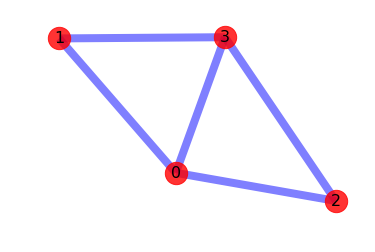

In [76]:
pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos,
                       node_color='r',
                       node_size=500,
                       alpha=0.8)

# edges
# nx.draw_networkx_edges(sub_graph,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(G, pos,
                       edgelist=G.edges(),
                       width=8, alpha=0.5, edge_color='b')


node_name = {}
for node in G.nodes():
    node_name[node] = str(node)


nx.draw_networkx_labels(G, pos, node_name, font_size=16)

plt.axis('off')
plt.show()  # display

In [77]:
nx.closeness_centrality(G)

{0: 1.0, 1: 0.75, 2: 0.75, 3: 1.0}

<li>n=4
<li>shortest paths from 2 (2-0:1, 2-3:1, 2-1:2) 
<li> (n-1)/sum = 3/4 = 0.75

<h2>Communicability</h2>
A measure of the degree to which one node can communicate with another<p>
Takes into account all paths between pairs of nodes<p>
The more paths, the higher the communicability

In [78]:
G = nx.Graph([(0, 1), (1, 2), (1, 5), (5, 4), (2, 4), (2, 3), (4, 3), (3, 6)])
nx.communicability(G)

{0: {0: 1.6474130416248864,
  1: 1.64007982238277,
  2: 0.8368311951157547,
  3: 0.35720896060478546,
  4: 0.520174745560531,
  5: 0.7619556594847192,
  6: 0.07487553563103588},
 1: {0: 1.64007982238277,
  1: 3.2461998962253578,
  2: 2.517463528548085,
  3: 1.4318814763073235,
  4: 1.9559958152052572,
  5: 2.1602545679433014,
  6: 0.35720896060478535},
 2: {0: 0.8368311951157547,
  1: 2.517463528548085,
  2: 3.9043895619138813,
  3: 3.106325592662368,
  4: 3.299674808862185,
  5: 1.8928564307083025,
  6: 1.0115331312055806},
 3: {0: 0.35720896060478546,
  1: 1.4318814763073235,
  2: 3.106325592662368,
  3: 3.6875182434266485,
  4: 3.0961977822476796,
  5: 1.3671337510909778,
  6: 1.7391918415713925},
 4: {0: 0.520174745560531,
  1: 1.9559958152052572,
  2: 3.299674808862185,
  3: 3.0961977822476796,
  4: 3.851377987831617,
  5: 2.2897500183759942,
  6: 1.009924790486192},
 5: {0: 0.7619556594847192,
  1: 2.1602545679433014,
  2: 1.8928564307083025,
  3: 1.3671337510909778,
  4: 2.28975

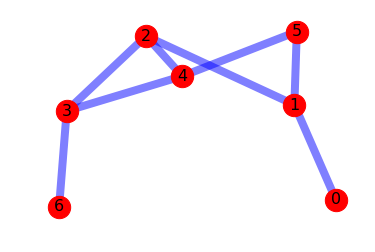

In [79]:
# Define a layout for the graph
pos = nx.spring_layout(G)  # positions for all nodes

# draw the nodes: red, sized, transperancy
nx.draw_networkx_nodes(G, pos,
                       node_color='r',
                       node_size=500,
                       alpha=1)

# draw the edges
nx.draw_networkx_edges(G, pos,
                       width=8, alpha=0.5, edge_color='b')


node_name = {}
for node in G.nodes():
    node_name[node] = str(node)


nx.draw_networkx_labels(G, pos, node_name, font_size=16)

plt.axis('off')
plt.show()  # display

In [ ]:
# communicability is the sum of closed walks of different lengths between nodes.
# communicability(friend_graph) #Costly operation, we won't do this. Try it at home!

<h2>Betweenness centrality</h2>
<h3>measures of the extent to which a node is connected to other nodes that are not connected to each other. </h3> 
<h3>It’s a measure of the degree to which a node serves as a connector</h3>
<h3>Example: a traffic bottleneck</h3>


<h4>The number of shortest paths that go through node n/total number of shortest paths</h4>

In [80]:
G = nx.complete_graph(4)
nx.betweenness_centrality(G)

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}

<h3>When the graph is fully connected, no shortest paths go through the node. So the numerator is zero</h3>

In [81]:
G.remove_edge(1, 2)
nx.betweenness_centrality(G)

{0: 0.16666666666666666, 1: 0.0, 2: 0.0, 3: 0.16666666666666666}

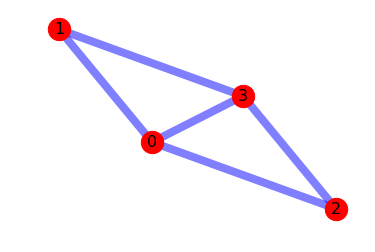

In [82]:
# Define a layout for the graph
pos = nx.spring_layout(G)  # positions for all nodes

# draw the nodes: red, sized, transperancy
nx.draw_networkx_nodes(G, pos,
                       node_color='r',
                       node_size=500,
                       alpha=1)

# draw the edges
nx.draw_networkx_edges(G, pos,
                       width=8, alpha=0.5, edge_color='b')


node_name = {}
for node in G.nodes():
    node_name[node] = str(node)


nx.draw_networkx_labels(G, pos, node_name, font_size=16)

plt.axis('off')
plt.show()  # display

In [83]:
nx.all_pairs_shortest_path(G)

{0: {0: [0], 1: [0, 1], 2: [0, 2], 3: [0, 3]},
 1: {0: [1, 0], 1: [1], 2: [1, 0, 2], 3: [1, 3]},
 2: {0: [2, 0], 1: [2, 0, 1], 2: [2], 3: [2, 3]},
 3: {0: [3, 0], 1: [3, 1], 2: [3, 2], 3: [3]}}

<h3>There are 12 shortest paths in total</h3>
<h3>Two go through 0 (1, 0, 2) and (2, 0, 1)</h3>
<h3> Betweeness centrality: 2/12</h3>

In [84]:
nx.betweenness_centrality(friend_graph)

{1: 0.20740728789527996,
 2: 0.0985001688738976,
 3: 0.007536740033300805,
 4: 0.0,
 5: 0.00015738788609320986,
 6: 0.030518654784294552,
 7: 8.813876743078566e-05,
 13: 0.00020265572799027523,
 15: 0.010554409674127914,
 94: 0.0001114998738147397,
 100: 0.027615000020366782,
 455: 0.0,
 1084: 0.05655944171100304,
 1349: 1.8215499386053798e-05,
 1435: 0.005820079305230333,
 1530: 0.000296787166320643,
 1531: 0.0008252414453598403,
 1613: 0.00021170967038451453,
 1806: 0.0017754093561129477,
 2200: 0.051109803521955856,
 2444: 0.00036957380391060496,
 2445: 0.0,
 2533: 0.0003906143234095072,
 2538: 0.007168624508418088,
 2893: 0.0009665179482218253,
 3069: 0.00036579307237703834,
 3071: 0.0,
 3073: 0.0011793730604171136,
 3074: 0.03486498330333773,
 3157: 0.0003428769372089461,
 3343: 0.00036627673121552423,
 3620: 0.003765602919847397,
 3700: 0.031646094803443624,
 4248: 0.0007763128181023414,
 4253: 0.0,
 4339: 0.002341645980741947,
 4516: 0.0002410264848180878,
 5052: 0.0012207556663

<h3>Dispersion in fully connected graphs</h3>
<li>Eccentricity: the max distance from one node to all other nodes (least eccentric is more central)
<li>diameter: the max eccentricity of all nodes in a graph (the longest shortest path)
<li>periphery: the set of nodes with eccentricity = diameter

In [85]:
G = nx.complete_graph(4)
nx.eccentricity(G)

{0: 1, 1: 1, 2: 1, 3: 1}

In [86]:
G.remove_edge(1, 2)
nx.eccentricity(G)

{0: 1, 1: 2, 2: 2, 3: 1}

<h2>Diameter</h2>
The longest shortest path in the graph
<h2>Periphery</h2>
The nodes with the longest shortest paths (the peripheral nodes)

In [87]:
nx.diameter(G)

2

In [88]:
nx.periphery(G)

[1, 2]

In [89]:
nx.diameter(friend_graph)

NetworkXError: Graph not connected: infinite path length

In [90]:
nx.periphery(friend_graph)

NetworkXError: Graph not connected: infinite path length

In [91]:
G = nx.complete_graph(4)
print(nx.diameter(G))
print(nx.periphery(G))

1
[0, 1, 2, 3]


In [92]:
G.remove_edge(1, 2)
print(nx.diameter(G))
print(nx.periphery(G))

2
[1, 2]


<h3>Cliques</h3>
A clique is a subgraph in which every node is connected to every other node

In [ ]:
from networkx.algorithms.clique import find_cliques, cliques_containing_node

In [ ]:
for clique in find_cliques(friend_graph):
    print(clique)

In [ ]:
cliques_containing_node(friend_graph, 2)

In [ ]:
# nx.draw(nx.make_max_clique_graph(friend_graph))

<h3>Center: The set of nodes that are the most central (they have the smallest distance to any other node)</h3>
Graph must be fully connected

In [ ]:
from networkx.algorithms.distance_measures import center
center(largest_graph)